In [1]:
# Import functions
import numpy as np
import matplotlib.pyplot as p
% matplotlib inline

import lightcurves_sh
import kmeans
import mapPCA
import bin_eigenspectra

from importlib import import_module
planet_name = 'HD189733b'
system = import_module('data.planet.{}'.format(planet_name))

### Creat a fake data set

Fake data 1, two distince spectra

(10, 6, 4)


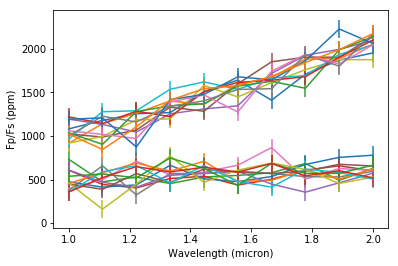

In [2]:
lamdim = 10
latdim = 6
londim = 4
ngroups = 2

# dummy flux values
waves = np.linspace(1,2,lamdim) # micron
spec1 = np.linspace(1000,2000,lamdim) # in ppm
spec2 = np.linspace(500,600,lamdim) # in ppm

spectra1 = [[ spec1+np.random.normal(0,100,lamdim) for _ in range(latdim) ] for __ in range(londim//2)]
spectra2 = [[ spec2+np.random.normal(0,100,lamdim) for _ in range(latdim) ] for __ in range(londim//2)]
fp_grid = np.array(spectra1+spectra2).T
print(fp_grid.shape) # should be wave, lat, lon


for lat in range(latdim):
    for lon in range(londim):
        spec = fp_grid[:,lat,lon]
        err = 100 # ppm
        p.errorbar(waves, spec, err)
p.ylabel('Fp/Fs (ppm)')
p.xlabel('Wavelength (micron)')
p.show()

Fake data 2, smoothly varying spectra

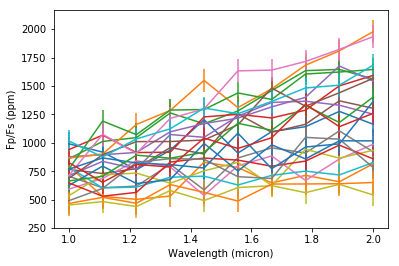

In [11]:
fp_grid2 = np.empty((lamdim,latdim,londim))
for lat in range(latdim):
    for lon in range(londim):
        f = np.random.uniform(0,1)
        err = np.random.normal(0,100,lamdim)
        fp_grid2[:, lat, lon] = f*spec1 + (1-f)*spec2 + err


for lat in range(latdim):
    for lon in range(londim):
        spec = fp_grid2[:,lat,lon]
        err = 100 # ppm
        p.errorbar(waves, spec, err)
p.ylabel('Fp/Fs (ppm)')
p.xlabel('Wavelength (micron)')
p.show()

### Get groups from K-means clustering

In [4]:
kgroups = kmeans.kmeans(fp_grid, ngroups)

kgroups2 = kmeans.kmeans(fp_grid2, ngroups)

### Create eigenspectra from K-mean clustering output

In [12]:
eigenspectra = bin_eigenspectra.bin_eigenspectra(fp_grid, kgroups)

eigenspectra2 = bin_eigenspectra.bin_eigenspectra(fp_grid2, kgroups2)

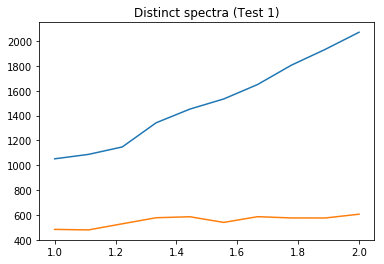

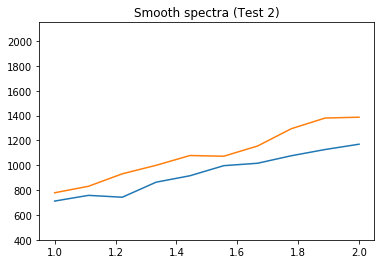

In [14]:
for spec in eigenspectra:
    p.plot(waves, spec)
p.title('Distinct spectra (Test 1)')
ylim = p.ylim()
p.show()

for spec in eigenspectra2:
    p.plot(waves, spec)
p.title('Smooth spectra (Test 2)')
p.ylim(ylim)
p.show()